https://github.com/pymc-devs/pymc3/pull/2876

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pylab as plt

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Cherry picked old commit

In [2]:
from pymc3.model import modelcontext, get_named_nodes_and_relations
from pymc3.util import is_transformed_name, get_untransformed_name
from tqdm import tqdm


def sample_prior(samples=500, model=None, vars=None, size=None,
                 random_seed=None, progressbar=True):
    """Generate samples from the prior of a model.

    Parameters
    ----------
    samples : int
        Number of samples from the prior to generate. Defaults to 500.
    model : Model (optional if in `with` context)
    vars : iterable
        Variables for which to compute the posterior predictive samples.
        Defaults to `model.named_vars`.
    size : int
        The number of random draws from the distribution specified by the
        parameters in each sample of the trace.
    random_seed : int
        Seed for the random number generator.
    progressbar : bool
        Whether or not to display a progress bar in the command line.

    Returns
    -------
    dict
        Dictionary with the variables as keys. The values are arrays of prior samples.
    """

    model = modelcontext(model)

    if vars is None:
        vars = set(model.named_vars.keys())

    if random_seed is not None:
        np.random.seed(random_seed)

    if progressbar:
        indices = tqdm(range(samples))

    def step(model):
        point = {}
        for var in model.basic_RVs:
            var_name = var.name
            if hasattr(var, 'distribution'):
                if is_transformed_name(var_name):
                    val = var.distribution.dist.random(
                        point=point, size=size)
                    var_name_untranf = get_untransformed_name(var_name)
                    point[var_name_untranf] = val
                    val = var.distribution.transform_used.forward_val(val)
                else:
                    val = var.distribution.random(point=point, size=size)
            else:
                nn, _, _ = get_named_nodes_and_relations(var)
                val = var.eval({model.named_vars[v]: point[v]
                                for v in nn})

            point[var_name] = val
        return point

    try:
        prior = {var: [] for var in vars}
        for _ in indices:
            point = step(model)
            for var_name, var in model.named_vars.items():
                if var_name in vars:
                    if var_name in point:
                        val = point[var_name]
                    else:
                        nn, _, _ = get_named_nodes_and_relations(var)
                        val = var.eval({model.named_vars[v]: point[v]
                                        for v in nn})
                    prior[var_name].append(val)

    except KeyboardInterrupt:
        pass

    finally:
        if progressbar:
            indices.close()

    return {k: np.asarray(v) for k, v in prior.items()}

In [3]:
observed = np.random.normal(10, 1, size=200)
with pm.Model() as m: 
    # Use a prior that's way off to show we're actually sampling from it 
    mu = pm.Normal('mu', mu=-10, sd=1) 
    positive_mu = pm.Deterministic('positive_mu', np.abs(mu)) 
    pm.Normal('x_obs', mu=mu, sd=1, observed=observed) 
    prior = sample_prior() 

assert (prior['mu'] < 0).all() 
assert (prior['positive_mu'] > 0).all() 
assert (prior['x_obs'] < 0).all()

100%|██████████| 500/500 [00:00<00:00, 906.69it/s]


## More complex example

In [4]:
data = pd.read_table(pm.get_data('efron-morris-75-data.tsv'), sep="\t")
at_bats, hits = data[['At-Bats', 'Hits']].values.T
N = len(hits)

### Reference numpy implementation

In [5]:
import scipy.stats as stats

In [6]:
def model_prior_sample(nsample):
    phi = stats.beta.rvs(1., 1., size=nsample)
    logkappa = np.random.exponential(1/5., nsample)
    kappa = np.exp(logkappa)
    thetas = stats.beta.rvs(phi*kappa, (1.-phi)*kappa, size=(N, nsample))
    y = stats.binom.rvs(n=at_bats[:, None], p=thetas)
    
    psample = {}
    psample['phi'] = phi
    psample['logkappa'] = logkappa
    psample['kappa'] = kappa
    psample['thetas'] = thetas.T
    psample['y'] = y.T
    return psample

In [7]:
%%time

psample0 = model_prior_sample(10000)

CPU times: user 83.2 ms, sys: 9.07 ms, total: 92.3 ms
Wall time: 110 ms


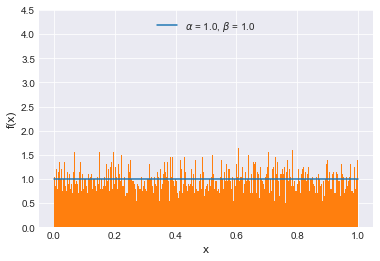

In [8]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 1, 200)
a = 1.
b = 1.
pdf = stats.beta.pdf(x, a, b)
plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.hist(psample0['phi'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

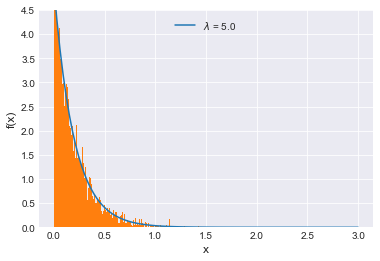

In [9]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 3, 100)
lam = 5.
pdf = stats.expon.pdf(x, scale=1.0/lam)
plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
plt.hist(psample0['logkappa'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

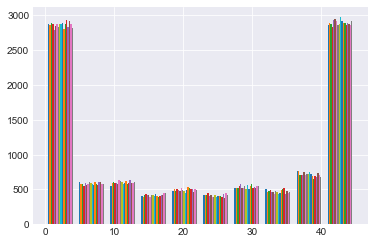

In [10]:
plt.hist(psample0['y']);

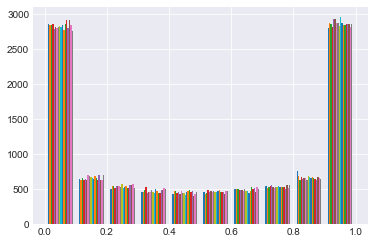

In [11]:
plt.hist(psample0['thetas']);

In [12]:
psample0['thetas'].mean(axis=0) * at_bats

array([22.62186866, 22.66910514, 22.47812277, 22.47733257, 22.84659448,
       22.78806546, 22.5779107 , 22.52973095, 22.51503522, 22.87777591,
       22.55782772, 22.61477038, 22.53195831, 22.43464909, 22.48756319,
       22.4262004 , 22.45774127, 22.62966416])

In [13]:
psample0['y'].mean(axis=0)

array([22.6114, 22.6423, 22.4651, 22.4668, 22.8739, 22.8093, 22.5945,
       22.548 , 22.5196, 22.8496, 22.5454, 22.6256, 22.5631, 22.43  ,
       22.4815, 22.4217, 22.4898, 22.6443])

### Check old implementation

In [14]:
with pm.Model() as model:
    phi = pm.Beta('phi', alpha=1., beta=1.)

    kappa_log = pm.Exponential('logkappa', lam=5.)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta('thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=N)

    y = pm.Binomial('y', n=at_bats, p=thetas, shape=N, observed=hits)

In [15]:
y.distribution.random(point=model.test_point, size=1000)

array([[20,  3, 23, ...,  0,  8, 17],
       [22,  5, 33, ...,  0,  7, 15],
       [11,  4, 27, ...,  1, 12, 22],
       ...,
       [10,  5, 28, ...,  0,  6, 19],
       [17,  1, 21, ...,  2,  5, 14],
       [13,  2, 30, ...,  0,  5, 22]])

In [16]:
np.random.binomial(45, thetas.tag.test_value, size=(1000, N))

array([[17, 19, 22, ..., 25, 22, 26],
       [24, 23, 19, ..., 22, 18, 17],
       [20, 23, 20, ..., 22, 22, 20],
       ...,
       [24, 29, 23, ..., 30, 25, 25],
       [21, 23, 22, ..., 18, 21, 27],
       [23, 19, 24, ..., 25, 22, 21]])

In [17]:
# names = ['phi', 'kappa_log', 'kappa', 'thetas', 'y']
# values = pm.distributions.draw_values([model[name] for name in names], size=100)
# p = {k: v for k, v in zip(names, values)}

In [18]:
%%time
psample1 = sample_prior(10000, model=model)

100%|██████████| 10000/10000 [00:42<00:00, 232.92it/s]


CPU times: user 36 s, sys: 1.08 s, total: 37.1 s
Wall time: 43 s


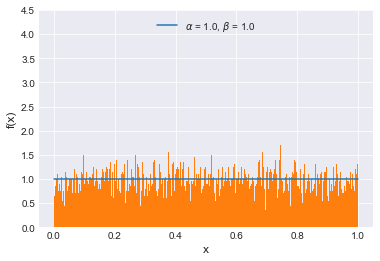

In [19]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 1, 200)
a = 1.
b = 1.
pdf = stats.beta.pdf(x, a, b)
plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.hist(psample1['phi'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

In [20]:
np.min(psample1['phi']), np.max(psample1['phi'])

(2.2443597121170175e-05, 0.9998956843410121)

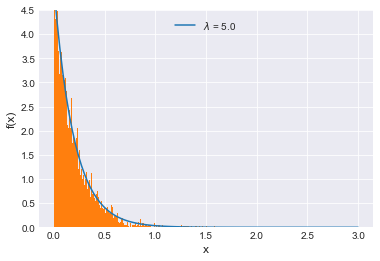

In [21]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 3, 100)
lam = 5.
pdf = stats.expon.pdf(x, scale=1.0/lam)
plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
plt.hist(psample1['logkappa'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

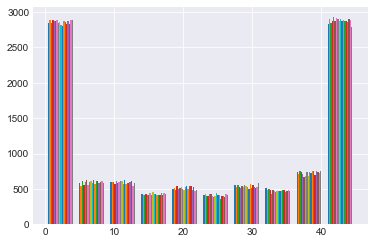

In [22]:
plt.hist(psample1['y']);

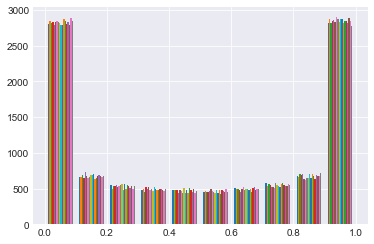

In [23]:
plt.hist(psample1['thetas']);

In [24]:
psample1['thetas'].mean(axis=0) * at_bats

array([22.60232177, 22.59946392, 22.59465147, 22.57207228, 22.56594379,
       22.42066101, 22.53264967, 22.61126441, 22.40865072, 22.75216949,
       22.55690667, 22.61866748, 22.52501488, 22.56745978, 22.50303913,
       22.68654429, 22.52261059, 22.44514096])

In [25]:
psample1['y'].mean(axis=0)

array([22.5995, 22.6004, 22.5902, 22.5727, 22.5392, 22.4167, 22.5623,
       22.6214, 22.4297, 22.7326, 22.5592, 22.6622, 22.5462, 22.5754,
       22.5023, 22.6658, 22.5378, 22.4348])

### Check new implementation

In [57]:
import scipy.stats as st

In [59]:
st.gumbel_l??

In [53]:
from pymc3.distributions.distribution import draw_values

with pm.Model() as m:
    p = pm.Beta('p', 1., 1.)
draw_values([m['p']], size=10)

[array(0.39081367)]

In [56]:
import theano

X = theano.shared(np.arange(3))
with pm.Model() as m:
    ind = pm.Categorical('i', np.ones(3)/3)
    x = pm.Deterministic('X', X[ind])
prior = pm.sample_generative(10, model=m)

AttributeError: 'numpy.ndarray' object has no attribute 'name'

In [55]:
prior

{'kappa': array(1.39834977),
 'logkappa': array(0.33529281),
 'logkappa_log__': array(-1.09275108),
 'phi': array(0.33400407),
 'phi_logodds__': array(-0.6901304),
 'thetas': array([0.98402388, 0.97923323, 0.60276499, 0.96337239, 0.58269224,
        0.71809118, 0.99873197, 0.99858847, 0.61532194, 0.98046268,
        0.60136073, 0.65791052, 0.99447163, 0.99811753, 0.0337185 ,
        0.99443494, 0.25343046, 0.98738162]),
 'thetas_logodds__': array([ 4.12055531,  3.85341591,  0.41699931,  3.26963759,  0.33383517,
         0.93501286,  6.6690237 ,  6.56166976,  0.46973882,  3.91569818,
         0.41113803,  0.65399658,  5.19231916,  6.27328795, -3.35540848,
         5.18566667, -1.08039933,  4.35990177]),
 'y': array([[42, 43, 28, 45, 41, 44, 39, 36,  8, 44, 41, 45, 42, 45, 42, 45,
         44, 30],
        [41, 40, 24, 45, 44, 44, 42, 40,  7, 45, 34, 45, 45, 45, 45, 45,
         45, 37],
        [38, 43, 23, 45, 44, 43, 42, 38,  7, 45, 37, 45, 45, 45, 43, 44,
         45, 37],
        [3

In [26]:
%%time
psample1 = pm.sample_generative(10000, model=model)

CPU times: user 2.44 s, sys: 338 ms, total: 2.78 s
Wall time: 5.09 s


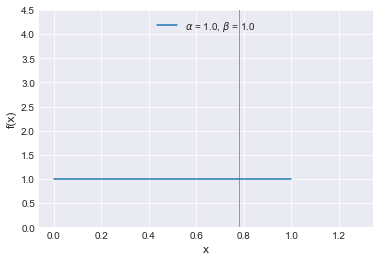

In [27]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 1, 200)
a = 1.
b = 1.
pdf = stats.beta.pdf(x, a, b)
plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.hist(psample1['phi'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

In [28]:
np.min(psample1['phi']), np.max(psample1['phi'])

(0.7805232658529404, 0.7805232658529404)

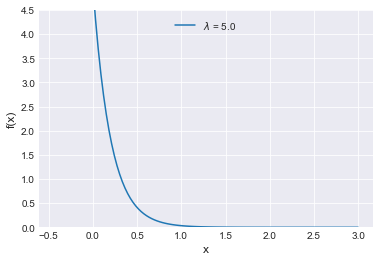

In [29]:
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 3, 100)
lam = 5.
pdf = stats.expon.pdf(x, scale=1.0/lam)
plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
plt.hist(psample1['logkappa'], 500, normed=True);
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0, 4.5)
plt.legend(loc=9)
plt.show()

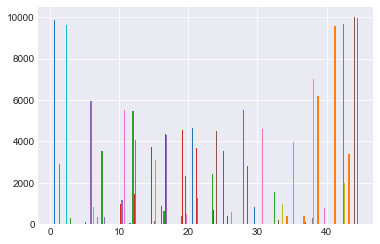

In [30]:
plt.hist(psample1['y']);

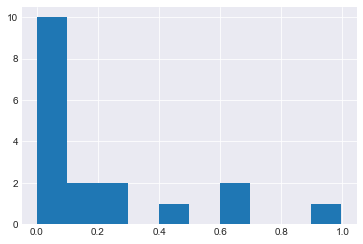

In [31]:
plt.hist(psample1['thetas']);

In [32]:
psample1['thetas'].mean(axis=0) * at_bats

array([9.5118185, 9.5118185, 9.5118185, 9.5118185, 9.5118185, 9.5118185,
       9.5118185, 9.5118185, 9.5118185, 9.5118185, 9.5118185, 9.5118185,
       9.5118185, 9.5118185, 9.5118185, 9.5118185, 9.5118185, 9.5118185])

In [33]:
psample1['y'].mean(axis=0)

array([ 1.3857, 43.1077, 28.326 , 17.7414,  5.832 , 24.7464, 12.5241,
       43.2505, 38.517 ,  1.8574, 21.9432, 39.4978,  9.3836, 16.8215,
       13.988 , 44.9824, 31.3074, 44.1664])

In [34]:
vars = set(model.named_vars.keys())

In [ ]:
names = pm.util.get_default_varnames(model.named_vars, include_transformed=False)
# draw_values fails with auto-transformed variables. transform them later!

In [42]:
print([name for name in names])

['kappa', 'y', 'logkappa', 'phi', 'thetas']


In [40]:
values = draw_values([model[name] for name in names], size=1000)

In [45]:
draw_values([model['phi']], size=1000)

[array(0.99917464)]

### sample from prior with sampler

In [13]:
with pm.Model() as model_:
    phi = pm.Beta('phi', alpha=1., beta=1.)

    kappa_log = pm.Exponential('logkappa', lam=5.)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta('thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=N)

    y = pm.Binomial('y', n=at_bats, p=thetas, shape=N)

In [27]:
%%time
with model_:
    psample2 = pm.sample(10000, tune=5000, chains=1, step=pm.Metropolis())

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [y]
>Metropolis: [thetas_logodds__]
>Metropolis: [logkappa_log__]
>Metropolis: [phi_logodds__]
100%|██████████| 15000/15000 [00:14<00:00, 1006.66it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 17.5 s, sys: 402 ms, total: 17.9 s
Wall time: 17.8 s


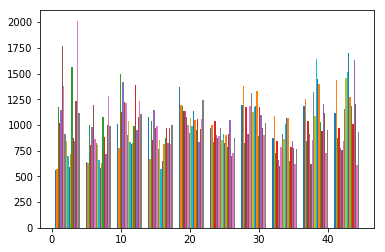

In [28]:
plt.hist(psample2['y']);

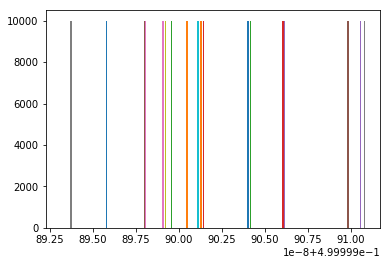

In [29]:
plt.hist(psample2['thetas']);

In [11]:
psample1['thetas'].mean(axis=0) * at_bats

array([29.17537646, 29.19002776, 29.15011068, 29.14314161, 29.14502391,
       29.16139058, 29.1881896 , 29.17654139, 29.19103725, 29.18007975,
       29.16310776, 29.13774703, 29.19948359, 29.15999634, 29.18637443,
       29.19694937, 29.16231964, 29.17803222])

In [12]:
psample1['y'].mean(axis=0)

array([27.9016, 27.851 , 27.989 , 27.8241, 27.801 , 28.0052, 27.8268,
       28.0808, 27.9234, 27.8336, 28.078 , 27.8091, 27.8389, 28.0057,
       27.9665, 27.8917, 27.9447, 27.8897])

##  Wrap in function 

In [35]:
from pymc3.step_methods.arraystep import BlockedStep
from pymc3.blocking import ArrayOrdering, DictToArrayBijection

class PriorStep(BlockedStep):
    """
    Blocked step method that is generalized to accept vectors of variables.

    Parameters
    ----------
    vars : list
        List of variables for sampler.
    model : PyMC Model
        Optional model for sampling step. Defaults to None (taken from context).
    allvars: Boolean (default True)
    blocked: Boolean (default True)
    """

    def __init__(self, vars=None, model=None, allvars=True, blocked=True):
        model = pm.modelcontext(model)

        if vars is None:
            vars = model.basic_RVs

        self.vars = vars
        self.model = model
        self.allvars = allvars
        self.blocked = blocked

    def step(self, point):
        model = self.model
        point = {}
        for var in self.vars:
            var_name = var.name
            if hasattr(var, 'distribution'):
                if is_transformed_name(var_name):
                    val = var.distribution.dist.random(
                        point=point, size=None)
                else:
                    val = var.distribution.random(point=point, size=None)
            else:
                nn, _, _ = get_named_nodes_and_relations(var)
                val = var.eval({model.named_vars[v]: point[v]
                                for v in nn})

            point[var_name] = val

        for var_name, var in model.named_vars.items():
            if not var_name in point:

                nn, _, _ = get_named_nodes_and_relations(var)
                val = var.eval({model.named_vars[v]: point[v]
                                for v in nn})
            point[var_name] = val
        return point

In [37]:
with model:
    step = PriorStep()

In [38]:
step.step(model.test_point)

TypeError: Bad input argument to theano function with name "<ipython-input-17-a594ea16b4a0>:72" at index 0 (0-based). Wrong number of dimensions: expected 1, got 0 with shape ().

In [ ]:
names = pm.util.get_default_varnames(model.named_vars, include_transformed=False)
names